## Описание проекта ##

**Задача:** Подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В распоряжении данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Для этого нужно:
1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

### Технологический процесс ###

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

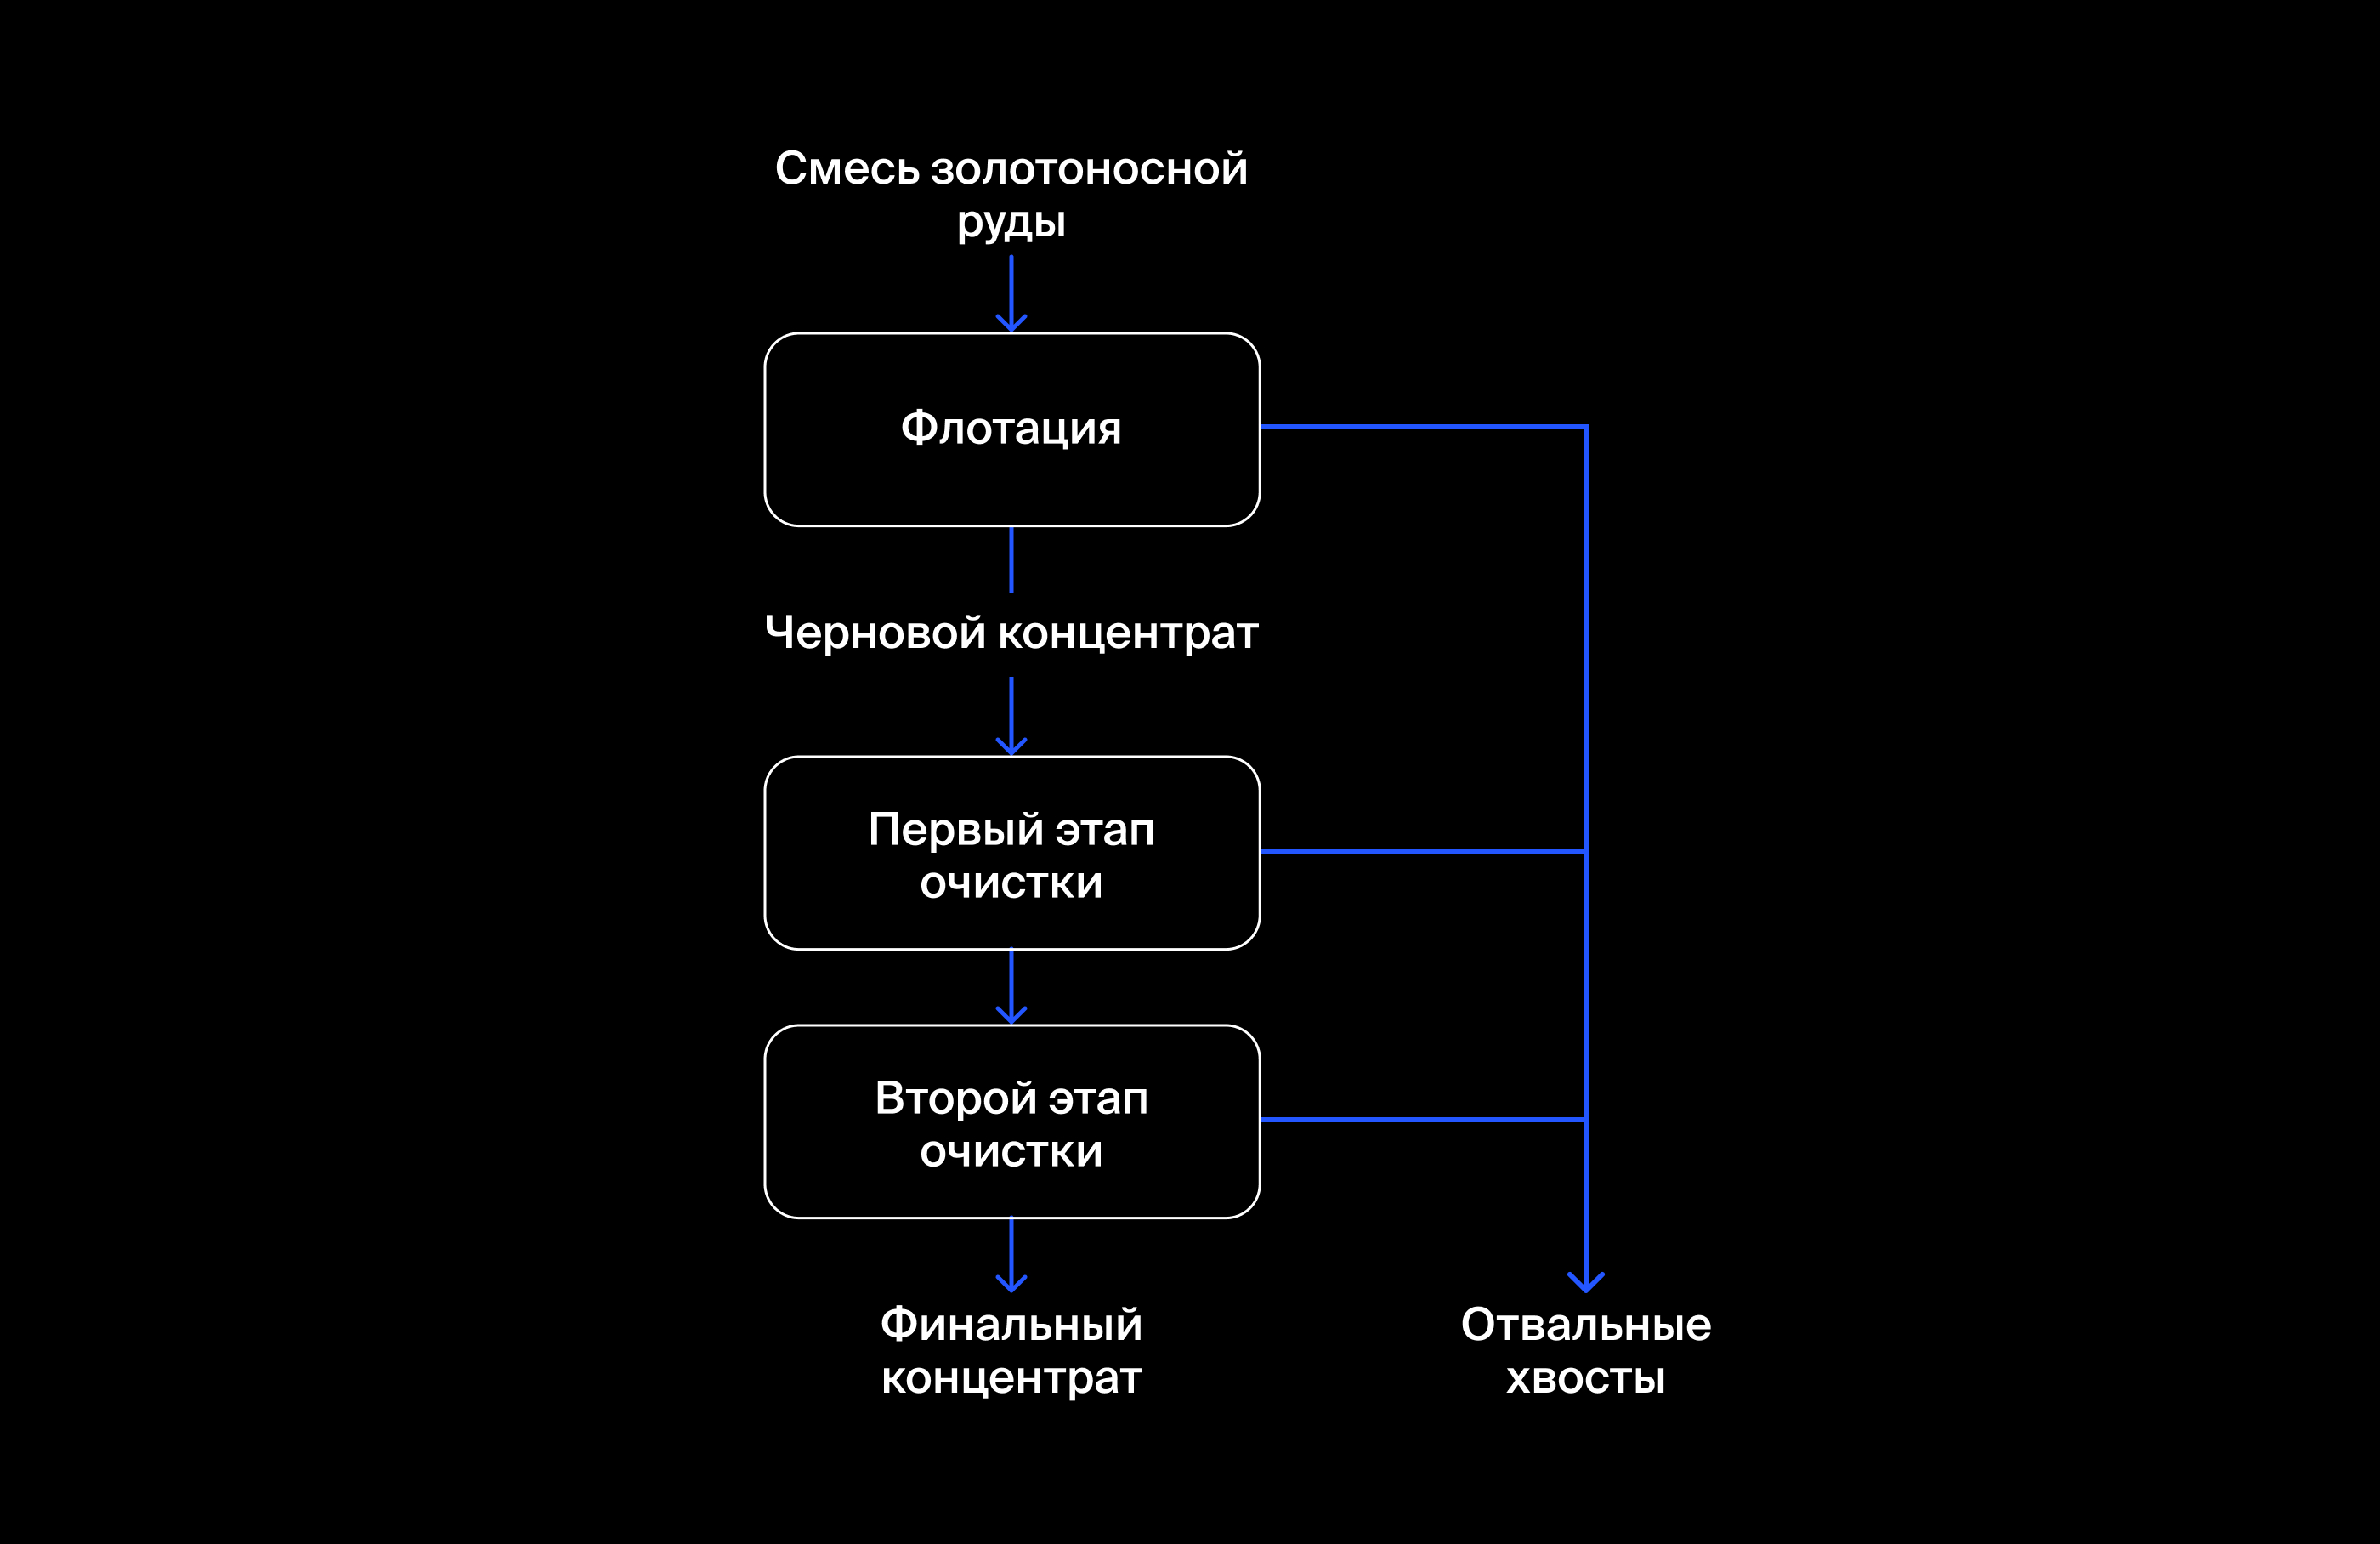

Опишем каждую стадию:

**1. Флотация**

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

**2. Очистка**

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

### Описание данных ###

**Технологический процесс**
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: *Xanthate, Sulphate, Depressant*
    * Xanthate** — ксантогенат (промотер, или активатор флотации);
    * Sulphate — сульфат (на данном производстве сульфид натрия);
    * Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

**Параметры этапов**
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

### Наименование признаков ###
Наименование признаков должно быть такое:
`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

Возможные значения для блока `[тип_параметра]`:
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики



### Расчёт эффективности ### 

Нужно смоделировать процесс восстановления золота из золотосодержащей руды.
Эффективность обогащения рассчитывается по формуле

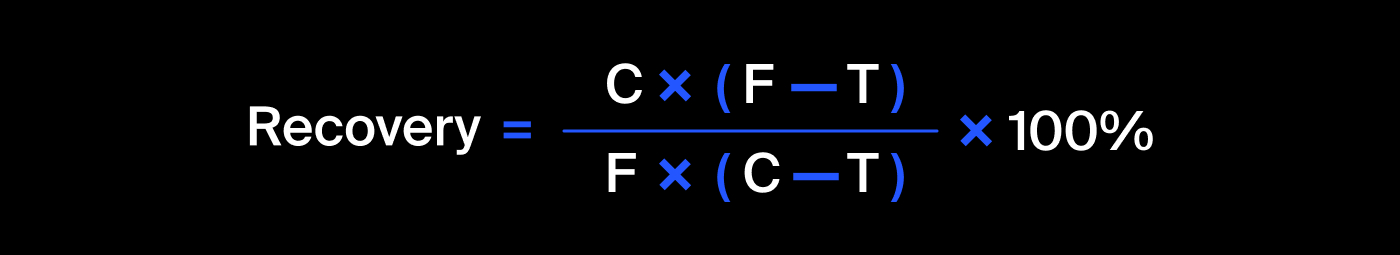

где:
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.


### Метрика качества ### 

Нужно спрогнозировать сразу две величины:
эффективность обогащения чернового концентрата rougher.output.recovery;
эффективность обогащения финального концентрата final.output.recovery.
Итоговая метрика складывается из двух величин:

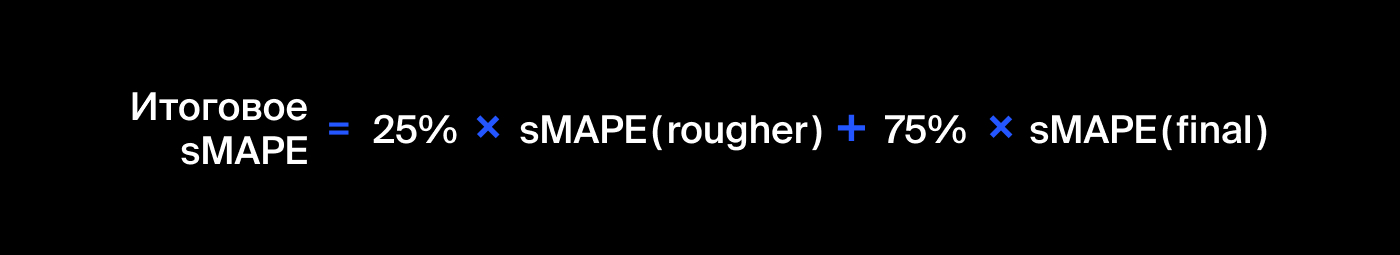


### Описание проекта ###

Данные находятся в трёх файлах:
* `gold_recovery_train_new.csv` — обучающая выборка;
* `gold_recovery_test_new.csv` — тестовая выборка;
* `gold_recovery_full_new.csv` — исходные данные.

Данные индексируются датой и временем получения информации (признак `date`). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

    
## Обзор данных ##

In [1]:
!pip install scikit-optimize

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyRegressor

from scipy.stats import kstest

from skopt import BayesSearchCV
from skopt.space import Integer

In [3]:
try:
    gold_train = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col='date')
    gold_test = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col='date')
    gold_full = pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col='date')
except:
    gold_train = pd.read_csv('gold_recovery_train_new.csv', index_col='date')
    gold_test = pd.read_csv('gold_recovery_test_new.csv', index_col='date')
    gold_full = pd.read_csv('gold_recovery_full_new.csv', index_col='date')
    
pd.set_option('display.max_columns', None)

In [4]:
gold_train.info()
gold_train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                             

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [5]:
gold_test.info()
gold_test.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289

In [6]:
gold_full.info()
gold_full.head()

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                             

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [7]:
print(gold_full.shape)
print(gold_train.shape)
print(gold_test.shape)

(19439, 86)
(14149, 86)
(5290, 52)


In [8]:
gold_test.shape[0] + gold_train.shape[0] == gold_full.shape[0]

True

In [9]:
print(gold_train.shape[0] / gold_full.shape[0])
print(gold_test.shape[0] / gold_full.shape[0])

0.7278666598076032
0.2721333401923967


In [10]:
gold_full.columns.difference(gold_test.columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

У нас имеются 3 датасета: `gold_full`, `gold_train` и `gold_test`, при этом `gold_train` и `gold_test` - это выборки из `gold_full`. 
В `gold_test` отсустсвуют столбцы, в которых содержатся данные по параметрам выходных продуктов на каждом этапе - судя по всему, эти данные рассчитываются позже. 

Тестовая выборка содержит в себе ~27% изначальных данных, тренировочная - ~73%.
Так же в данных содержится некоторое количество пропусков.

## Предобработка данных ##

### Проверка расчетов ###

Проверим правильность расчета параметра Recovery для признака `rougher.output.recovery`. Для этого воспользуемся формулой

Recovery = (C * (F - T)) / (F * (C - T)) * 100, где
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

In [11]:
calc_recovery = (
    ((gold_train['rougher.output.concentrate_au'] * 
     (gold_train['rougher.input.feed_au'] - gold_train['rougher.output.tail_au'])) / 
    (gold_train['rougher.input.feed_au'] * 
     (gold_train['rougher.output.concentrate_au'] - gold_train['rougher.output.tail_au'])))
    * 100)  

calc_recovery

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
                         ...    
2018-08-18 06:59:59    89.574376
2018-08-18 07:59:59    87.724007
2018-08-18 08:59:59    88.890579
2018-08-18 09:59:59    89.858126
2018-08-18 10:59:59    89.514960
Length: 14149, dtype: float64

In [12]:
gold_train['rougher.output.recovery']

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
                         ...    
2018-08-18 06:59:59    89.574376
2018-08-18 07:59:59    87.724007
2018-08-18 08:59:59    88.890579
2018-08-18 09:59:59    89.858126
2018-08-18 10:59:59    89.514960
Name: rougher.output.recovery, Length: 14149, dtype: float64

Для оценки правильности расчета расчитаем MAE.

In [13]:
mean_absolute_error(gold_train['rougher.output.recovery'], calc_recovery)

9.73512347450521e-15

MAE стремится к нулю - это значит, что практически ошибок в расчетах нет. Небольшие отклонения в значениях могут быть связаны с тем, как в Python реализована плавающая точка.

### Обработка пропусков ###

По условию задачи соседние по времени параметры часто похожи. Поэтому для заполнения пропущенных значений в `gold_full` возьмем среднее 2 ближайших соседей от пропуска.

In [14]:
gold_full[gold_full['rougher.calculation.sulfate_to_au_concentrate'].isna() == True]

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-21 10:00:00,5.782224,10.969985,9.301260,43.181003,74.257359,11.959760,2.064173,15.139256,3.091437,NaN,NaN,7.25,NaN,11.345656,9.424562,20.275368,31.333106,17.514891,3.971093,7.845526,3.162975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.367651,12.028591,4.203939,NaN,NaN,41.782570,9.953462,NaN,NaN,NaN,NaN,13.678706,7.790201,28.779023,19.650397,86.217222,6.055658,0.862177,19.770304,2.435464,NaN,NaN,NaN,NaN,NaN,NaN,1393.735867,-501.357678,1196.516363,-505.322143,1097.010735,-499.416892,16.134409,5.427901,12.116604,3.259027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-27 10:59:59,5.454124,10.327148,8.924429,45.368858,73.580496,13.077847,3.800537,11.514648,3.786579,NaN,NaN,7.20,0.028131,8.874217,12.889648,16.279297,33.581341,19.571922,5.476074,9.452148,4.076124,7.805874e-32,-782.505268,9.528241e-32,-496.652939,5.781792e-32,-799.960571,5.789652e-32,-799.79425,NaN,NaN,NaN,2.148174,11.450708,5.413574,NaN,NaN,41.058594,11.629298,NaN,0.015

In [15]:
gold_full = gold_full.interpolate(method='linear', axis=0, limit_direction='forward')

gold_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19439 non-null  float64
 1   final.output.concentrate_pb                         19439 non-null  float64
 2   final.output.concentrate_sol                        19439 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19439 non-null  float64
 6   final.output.tail_pb                                19439 non-null  float64
 7   final.output.tail_sol                               19439 non-null  float64
 8   final.output.tail_au                             

In [16]:
gold_full.loc['2016-01-21 08:00:00':'2016-01-21 12:00:00']

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-21 08:00:00,5.347829,11.035193,9.998993,44.700567,66.847030,11.829815,2.346114,17.558527,3.359253,188.311758,15.040277,7.25,1.201937,10.920014,10.087052,20.280595,31.785914,17.799157,4.163898,8.323255,3.279546,1545.968079,-500.211961,1548.831253,-499.798176,1551.060139,-500.834194,1548.946997,-499.581790,40189.734810,3192.182075,3183.067588,2.298960,9.886648,3.827497,597.903048,65.776580,40.368977,8.799262,18.059480,7.806600,18.072294,7.793935,13.018763,8.144993,28.855867,19.609210,81.321940,5.836625,1.014966,18.415686,2.587900,1000.552630,-499.242676,1600.159121,-500.928637,1599.341600,-500.529305,1397.345490,-500.271627,1199.586789,-499.457734,1099.651743,-500.963776,16.797286,5.653094,12.714007,3.426744,24.915406,-501.282384,23.147565,-500.201485,24.033832,-500.481236,22.806394,-500.328940,14.006919,-530.180523,12.070301,-549.915635,9.970226,-547.117814,8.015124,-499.648692,11.959992,-598.705923
2016-01-21 09:00:00,5.518476,10.996012,9.156174,43.715161,70.76855

Т.к. `gold_test` и `gold_train` являются выборками из `gold_full`, то данный метод для заполнения пропусков в них не подходит, т.к. соседние значения могут не быть ближайшими. Поэтому для них возьмем значения из `gold_full`.

In [17]:
gold_test[gold_test['primary_cleaner.input.sulfate'].isna()==True]

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-02 06:59:59,NaN,NaN,7.16,NaN,4.126292e+02,-795.316337,4.137033e+02,-787.396567,4.416043e+02,-799.942901,2.779496e+02,-799.760111,0.568441,0.273677,0.185161,73.863127,3.091118,0.568632,NaN,0.005559,0.002121,0.017055,802.900908,-522.987484,900.542913,-650.245277,1005.732206,-439.919433,1009.700913,-619.995695,676.186135,-649.267537,617.387077,-445.400385,15.220105,-725.426349,6.004391,-788.919901,0.000000e+00,-796.177023,6.203523e+00,-660.374105,6.576244e+00,-616.550019,4.625908e+00,-678.347958,4.451592,-795.337422,3.544708,-800.024373,5.914889,-799.501783
2017-09-26 12:59:59,NaN,0.003839,7.38,NaN,1.251845e+03,-471.118852,1.248264e+03,-550.127277,1.248422e+03,-524.630369,1.252382e+03,-498.630345,5.944761,3.683904,580.230262,54.908497,41.936350,7.197268,17.001744,5.996032,16.998585,7.555566,1003.969869,-299.197172,1301.225115,-498.713971,1248.491759,-499.365896,1199.062171,-499.997510,998.530738,-501.207848,998.394988,-497.637000,25.951425,-500.063257,21.109099,-500.108006,2.303274e+01,-500.119265,1.495191e+01,-499.988678,1.498183e+01,-499.100878,1.302851e+01,-399.180109,11.031989,-514.882414,9.077423,-344.179961,11.995561,-460.165587
2017-11-29 23:59:59,NaN,0.115705,7.60,0.010486,1.500190e+03,-500.592799,1.499241e+03,-499.368215,1.499806e+03,-520.567976,1.501409e+03,-501.474331,5.650235,2.786634,32.404389,30.252351,15.458575,5.970051,0.002683,0.001963,0.004423,0.096524,1195.119382,-398.453335,1202.227635,-496.943983,1201.609868,-496.863102,1001.445812,-497.050705,1002.252429,-497.480519,901.266231,-496.936109,28.000817,-499.787047,23.963136,-499.828187,2.499135e+01,-499.587180,2.003493e+01,-500.000034,1.700279e+01,-497.480272,1.498787e+01,-778.977540,10.934705,-497.792554,8.994251,-499.851597,12.006522,-497.487539
2017-12-27 10:59:59,NaN,NaN,7.20,0.028131,7.805874e-32,-782.505268,9.528241e-32,-496.652939,5.781792e-32,-799.960571,5.789652e-32,-799.794250,11.450708,5.413574,NaN,NaN,41.058594,11.629298,NaN,0.015914,NaN,0.006985,-0.020163,-651.930974,-0.661920,-650.065369,-0.056636,-647.544439,-0.992219,-76.397327,-1.982295,-638.51

In [18]:
test_na_indexes = gold_test[gold_test['primary_cleaner.input.sulfate'].isna()==True].index
test_na_indexes

Index(['2016-09-02 06:59:59', '2017-09-26 12:59:59', '2017-11-29 23:59:59',
       '2017-12-27 10:59:59'],
      dtype='object', name='date')

In [19]:
gold_test = gold_test.fillna(value=gold_full)
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5290 non-null   float64
 1   primary_cleaner.input.depressant            5290 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5290 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

In [20]:
gold_test.loc[test_na_indexes]

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-02 06:59:59,95.443993,4.032449,7.16,0.609889,4.126292e+02,-795.316337,4.137033e+02,-787.396567,4.416043e+02,-799.942901,2.779496e+02,-799.760111,0.568441,0.273677,0.185161,73.863127,3.091118,0.568632,9.713888,0.005559,0.002121,0.017055,802.900908,-522.987484,900.542913,-650.245277,1005.732206,-439.919433,1009.700913,-619.995695,676.186135,-649.267537,617.387077,-445.400385,15.220105,-725.426349,6.004391,-788.919901,0.000000e+00,-796.177023,6.203523e+00,-660.374105,6.576244e+00,-616.550019,4.625908e+00,-678.347958,4.451592,-795.337422,3.544708,-800.024373,5.914889,-799.501783
2017-09-26 12:59:59,116.081245,0.003839,7.38,1.102784,1.251845e+03,-471.118852,1.248264e+03,-550.127277,1.248422e+03,-524.630369,1.252382e+03,-498.630345,5.944761,3.683904,580.230262,54.908497,41.936350,7.197268,17.001744,5.996032,16.998585,7.555566,1003.969869,-299.197172,1301.225115,-498.713971,1248.491759,-499.365896,1199.062171,-499.997510,998.530738,-501.207848,998.394988,-497.637000,25.951425,-500.063257,21.109099,-500.108006,2.303274e+01,-500.119265,1.495191e+01,-499.988678,1.498183e+01,-499.100878,1.302851e+01,-399.180109,11.031989,-514.882414,9.077423,-344.179961,11.995561,-460.165587
2017-11-29 23:59:59,139.765540,0.115705,7.60,0.010486,1.500190e+03,-500.592799,1.499241e+03,-499.368215,1.499806e+03,-520.567976,1.501409e+03,-501.474331,5.650235,2.786634,32.404389,30.252351,15.458575,5.970051,0.002683,0.001963,0.004423,0.096524,1195.119382,-398.453335,1202.227635,-496.943983,1201.609868,-496.863102,1001.445812,-497.050705,1002.252429,-497.480519,901.266231,-496.936109,28.000817,-499.787047,23.963136,-499.828187,2.499135e+01,-499.587180,2.003493e+01,-500.000034,1.700279e+01,-497.480272,1.498787e+01,-778.977540,10.934705,-497.792554,8.994251,-499.851597,12.006522,-497.487539
2017-12-27 10:59:59,101.661548,14.991382,7.20,0.028131,7.805874e-32,-782.505268,9.528241e-32,-496.652939,5.781792e-32,-799.960571,5.789652e-32,-799.794250,11.450708,5.413574,531.626404,65.144402,41.058594,11.629298,13.002341,0.015914,6.179873,0.006985,-0.020163,-651.930974,-0.66

In [21]:
gold_full.loc[test_na_indexes, gold_test.columns]

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-02 06:59:59,95.443993,4.032449,7.16,0.609889,4.126292e+02,-795.316337,4.137033e+02,-787.396567,4.416043e+02,-799.942901,2.779496e+02,-799.760111,0.568441,0.273677,0.185161,73.863127,3.091118,0.568632,9.713888,0.005559,0.002121,0.017055,802.900908,-522.987484,900.542913,-650.245277,1005.732206,-439.919433,1009.700913,-619.995695,676.186135,-649.267537,617.387077,-445.400385,15.220105,-725.426349,6.004391,-788.919901,0.000000e+00,-796.177023,6.203523e+00,-660.374105,6.576244e+00,-616.550019,4.625908e+00,-678.347958,4.451592,-795.337422,3.544708,-800.024373,5.914889,-799.501783
2017-09-26 12:59:59,116.081245,0.003839,7.38,1.102784,1.251845e+03,-471.118852,1.248264e+03,-550.127277,1.248422e+03,-524.630369,1.252382e+03,-498.630345,5.944761,3.683904,580.230262,54.908497,41.936350,7.197268,17.001744,5.996032,16.998585,7.555566,1003.969869,-299.197172,1301.225115,-498.713971,1248.491759,-499.365896,1199.062171,-499.997510,998.530738,-501.207848,998.394988,-497.637000,25.951425,-500.063257,21.109099,-500.108006,2.303274e+01,-500.119265,1.495191e+01,-499.988678,1.498183e+01,-499.100878,1.302851e+01,-399.180109,11.031989,-514.882414,9.077423,-344.179961,11.995561,-460.165587
2017-11-29 23:59:59,139.765540,0.115705,7.60,0.010486,1.500190e+03,-500.592799,1.499241e+03,-499.368215,1.499806e+03,-520.567976,1.501409e+03,-501.474331,5.650235,2.786634,32.404389,30.252351,15.458575,5.970051,0.002683,0.001963,0.004423,0.096524,1195.119382,-398.453335,1202.227635,-496.943983,1201.609868,-496.863102,1001.445812,-497.050705,1002.252429,-497.480519,901.266231,-496.936109,28.000817,-499.787047,23.963136,-499.828187,2.499135e+01,-499.587180,2.003493e+01,-500.000034,1.700279e+01,-497.480272,1.498787e+01,-778.977540,10.934705,-497.792554,8.994251,-499.851597,12.006522,-497.487539
2017-12-27 10:59:59,101.661548,14.991382,7.20,0.028131,7.805874e-32,-782.505268,9.528241e-32,-496.652939,5.781792e-32,-799.960571,5.789652e-32,-799.794250,11.450708,5.413574,531.626404,65.144402,41.058594,11.629298,13.002341,0.015914,6.179873,0.006985,-0.020163,-651.930974,-0.66

In [22]:
gold_train = gold_train.fillna(value=gold_full)
gold_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14149 non-null  float64
 1   final.output.concentrate_pb                         14149 non-null  float64
 2   final.output.concentrate_sol                        14149 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14149 non-null  float64
 7   final.output.tail_sol                               14149 non-null  float64
 8   final.output.tail_au                             

Пропуски в датасетах обработаны.

## Анализ данных ##


### Анализ изменения концентрации металлов на разных этапах ###

Посмотрим, как меняется концентрация металлов (*Au, Ag, Pb*) на различных этапах очистки.

In [23]:
gold_train.loc[:,gold_train.columns.str.contains('concentrate_au|feed_au')]

,final.output.concentrate_au,primary_cleaner.output.concentrate_au,rougher.input.feed_au,rougher.output.concentrate_au
date,,,,
2016-01-15 00:00:00,42.192020,34.174427,6.486150,19.793808
2016-01-15 01:00:00,42.701629,34.118526,6.478583,20.050975
2016-01-15 02:00:00,42.657501,33.969464,6.362222,19.737170
2016-01-15 03:00:00,42.689819,28.260743,6.118189,19.320810
2016-01-15 04:00:00,42.774141,33.044932,5.663707,19.216101
...,...,...,...,...
2018-08-18 06:59:59,46.713954,32.940215,5.335862,18.603550
2018-08-18 07:59:59,46.866780,32.925325,4.838619,18.441436
2018-08-18 08:59:59,46.795691,31.856742,4.525061,15.111231


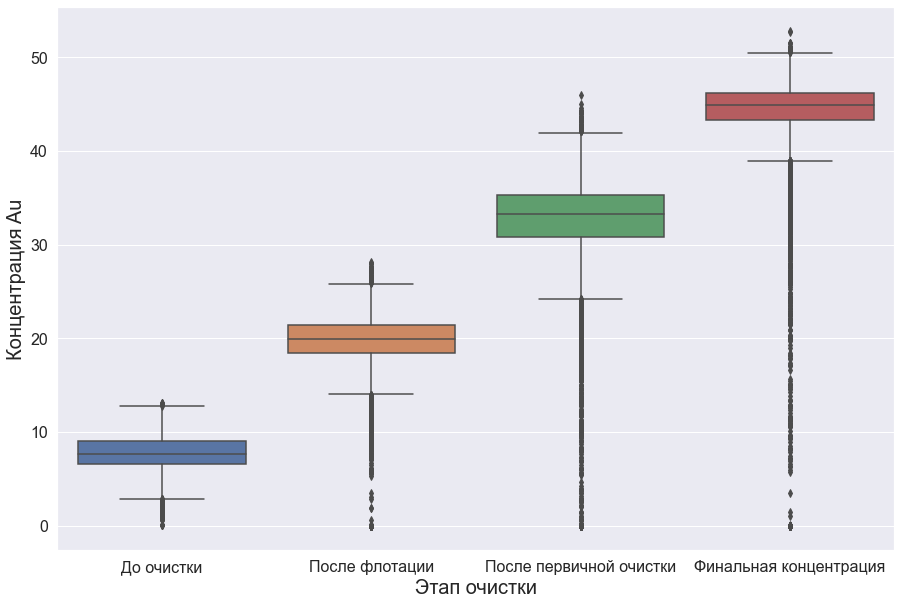

In [24]:
sns.set(rc={
    'figure.figsize':(15,10),
    'axes.labelsize':20,
    'xtick.labelsize':16,
    'ytick.labelsize':16,
})

(sns
.boxplot(
    data=gold_train.loc[:,gold_train.columns.str.contains('concentrate_au|feed_au')],
    order=['rougher.input.feed_au',
           'rougher.output.concentrate_au', 
           'primary_cleaner.output.concentrate_au',
           'final.output.concentrate_au'])
.set(xticklabels=['До очистки','После флотации', 'После первичной очистки', 'Финальная концентрация'],
     ylabel='Концентрация Au', xlabel='Этап очистки'));

Видно, что после каждого этапа очистки средний показатель концетрации золота увеличивается на ~10 единиц.

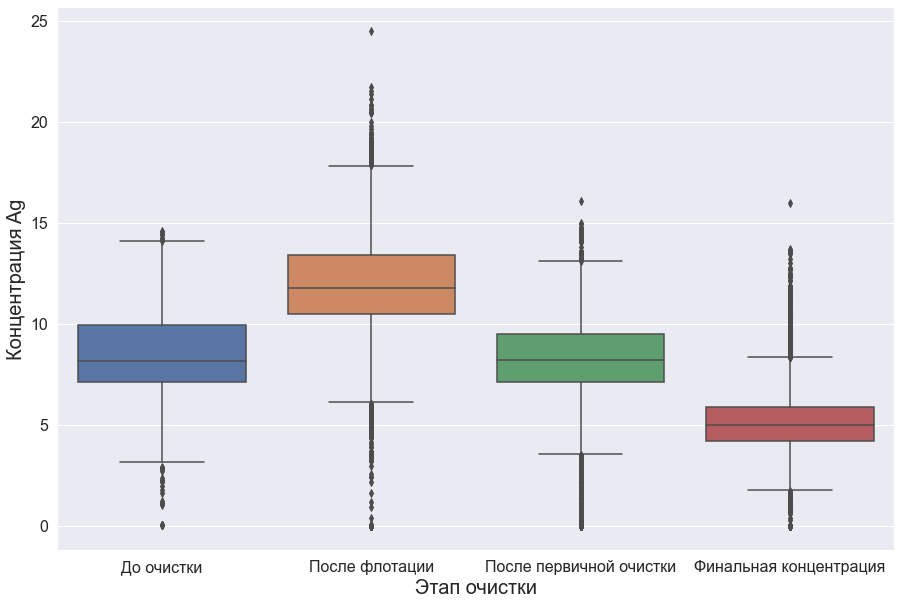

In [25]:
(sns
.boxplot(
    data=gold_train.loc[:,gold_train.columns.str.contains('concentrate_ag|feed_ag')],
    order=['rougher.input.feed_ag',
           'rougher.output.concentrate_ag', 
           'primary_cleaner.output.concentrate_ag',
           'final.output.concentrate_ag'])
.set(xticklabels=['До очистки','После флотации', 'После первичной очистки', 'Финальная концентрация'],
     ylabel='Концентрация Ag', xlabel='Этап очистки'));

Концетрация серебра немного увеличисается после флотации, однако на последующих этапах, она уменьщается.

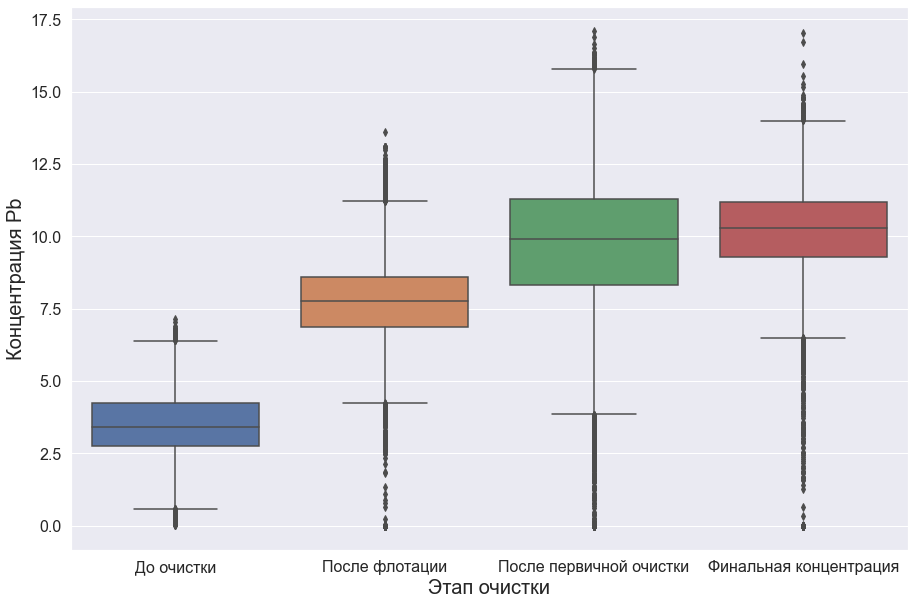

In [26]:
(sns
.boxplot(
    data=gold_train.loc[:,gold_train.columns.str.contains('concentrate_pb|feed_pb')],
    order=['rougher.input.feed_pb',
           'rougher.output.concentrate_pb', 
           'primary_cleaner.output.concentrate_pb',
           'final.output.concentrate_pb'])
.set(xticklabels=['До очистки','После флотации', 'После первичной очистки', 'Финальная концентрация'],
     ylabel='Концентрация Pb', xlabel='Этап очистки'));

Концентрация свинца растет на до вторичной очистки, при этом, увеличивается разброс ее значений. После вторичной очистки средняя концетрации осталось почти такой же, как после первичной, однако разброс уменьшился.

### Сравнение распределения размеров гранул сырья ###

Сравним размеры гранул сырья на обучающей и тестовой выборках. Размер сырья указан в параметре `feed_size`.

,primary_cleaner.input.feed_size,rougher.input.feed_size
count,14149.000000,14149.000000
mean,7.322310,60.097903
std,0.614062,23.023690
min,1.080000,9.659576
25%,6.960000,48.950593
50%,7.290000,55.269784
75%,7.700000,65.982466
max,10.470000,484.967466


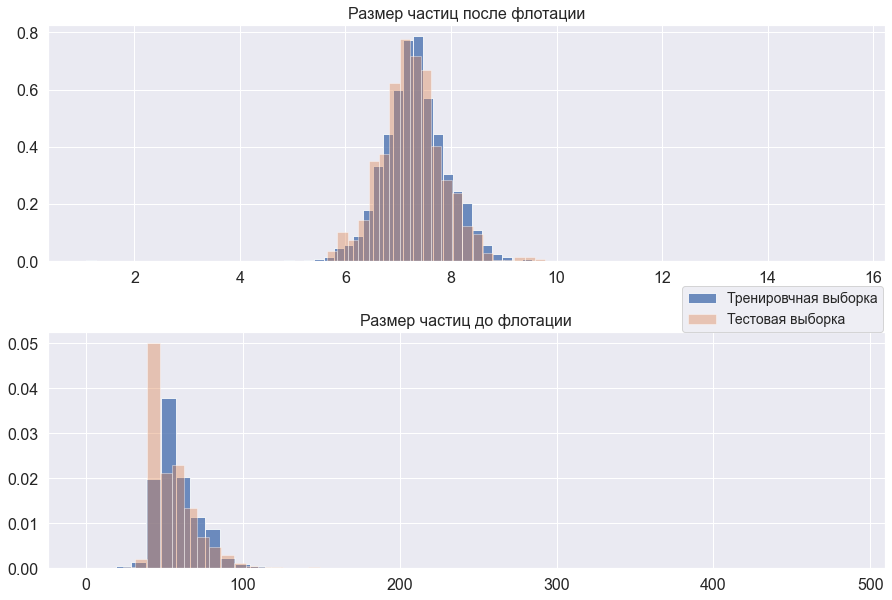

In [27]:
fig, ax = plt.subplots(2)

(gold_train.loc[:,gold_train.columns.str.contains('feed_size')]).hist(bins=50, ax=ax, density=True, alpha=0.8)
(gold_test.loc[:,gold_test.columns.str.contains('feed_size')]).hist(bins=50, ax=ax, density=True, alpha=0.4)

fig.legend(['Тренировчная выборка', 'Тестовая выборка'], fontsize=14, loc='center right',bbox_to_anchor=(0.905, 0.485))
ax[0].set_title('Размер частиц после флотации', fontsize=16);
ax[1].set_title('Размер частиц до флотации', fontsize=16);

gold_train.loc[:,gold_train.columns.str.contains('feed_size')].describe()

In [28]:
alpha = .01

input_results = kstest(gold_train['primary_cleaner.input.feed_size'], 
                 gold_test['primary_cleaner.input.feed_size'],
                 alternative='two-sided',
                 mode='asymp'
                         
)

print('P-value до флотации',input_results.pvalue)
if input_results.pvalue < alpha:
    print('Отвергаем гипотезу о том, что средние размеры гранул до флотации в выборках равны')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print()
output_results = kstest(gold_train['rougher.input.feed_size'], 
                 gold_test['rougher.input.feed_size'],
                 alternative='two-sided',
                 mode='asymp'
)
print('P-value после флотации',output_results.pvalue)
if output_results.pvalue < alpha:
    print('Отвергаем гипотезу о том, что средние размеры гранул после флотации в выборках равны')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

P-value до флотации 3.5273935105512727e-12
Отвергаем гипотезу о том, что средние размеры гранул до флотации в выборках равны

P-value после флотации 1.7378945370631348e-206
Отвергаем гипотезу о том, что средние размеры гранул после флотации в выборках равны


Гранулы сырья до флотации в тренировочной выборке имеют средний размер 60 мкм, на тестовой выборке - 56 мкм. Так как размеры гранул достаточно малы, будем считать эту разницу незначительной.

Размеры гранул после флотации на обеих выборках практически не отличаются.

### Исследование суммарной концентрации веществ на разных этапах обработки ###

Для налачала посчитаем суммарные концентрации всех веществ на разных этапах.

In [29]:
concentrates = ['feed_au','feed_ag','feed_pb', 'feed_sol', 'concentrate_au', 'concentrate_ag', 'concentrate_pb', 'concentrate_sol']
processes = {
    'rougher.input':0, 
    'rougher.output':0, 
    'primary_cleaner.output':0, 
    'final.output':0
}



for i in range(len(processes.keys())):
    for j in range(len(concentrates)):
        temp=f'{list(processes.keys())[i]+"."+concentrates[j]}'
        try:
            processes[list(processes.keys())[i]] += gold_full[temp]
        except:
            pass

processes = pd.DataFrame(processes)
processes

,rougher.input,rougher.output,primary_cleaner.output,final.output
date,,,,
2016-01-15 00:00:00,51.680034,66.424950,72.640924,63.644396
2016-01-15 01:00:00,50.659114,67.012710,72.543485,63.957723
2016-01-15 02:00:00,50.609929,66.103793,72.095042,64.311180
2016-01-15 03:00:00,51.061546,65.752751,59.957723,63.573449
2016-01-15 04:00:00,47.859163,65.908382,71.321010,64.004667
...,...,...,...,...
2018-08-18 06:59:59,53.415050,70.781325,59.001692,68.098589
2018-08-18 07:59:59,53.696482,70.539603,59.703912,68.274362
2018-08-18 08:59:59,54.589604,55.376330,59.561096,68.226068


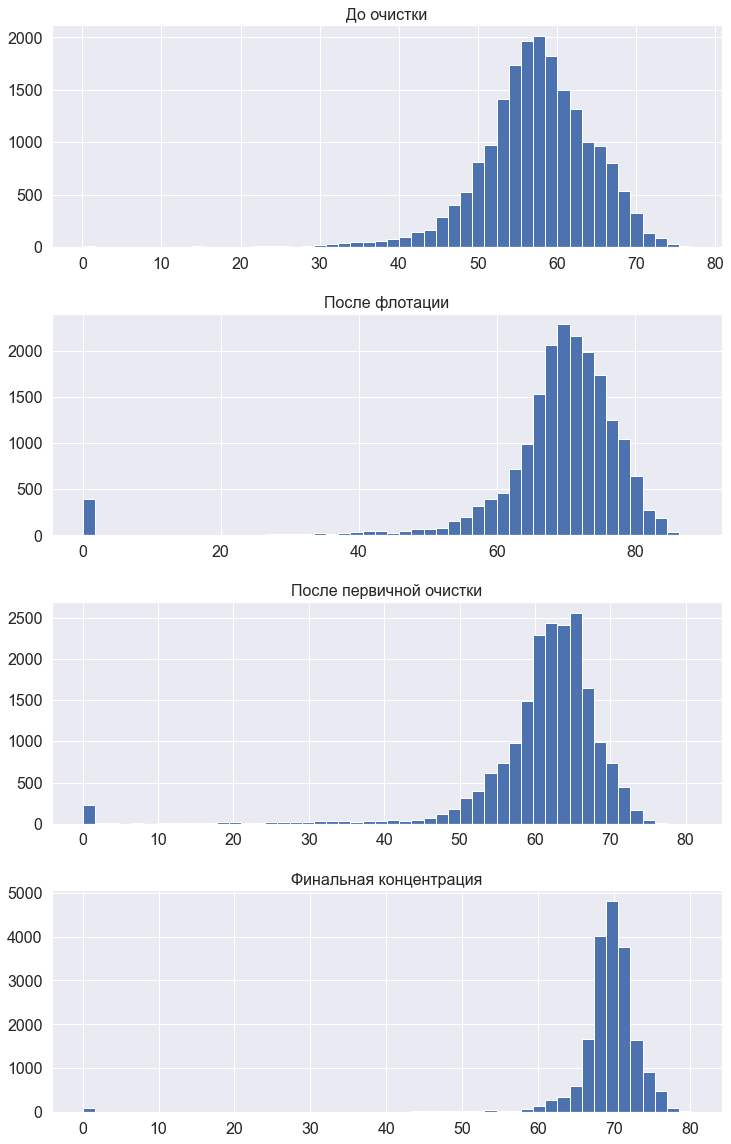

In [30]:
fig, ax = plt.subplots(4,1, figsize=(12,20))

processes.hist(bins=50,ax=ax);

titles = ['До очистки','После флотации', 'После первичной очистки', 'Финальная концентрация']

for i in range(len(titles)):
    ax[i].set_title(titles[i], fontsize=16);

По графикам видно, что благодаря очистке, суммарная концетрация веществ, во-первых, увеличивается, а во-вторых, у нее уменьшается разброс значений - большая часть находится в диапазоне от 65 до 75 на финальном этапе.

Кроме того видно, что после флотации в концентрациях появляются нулевые значения.

In [31]:
gold_full['rougher.output.concentrate_au'].value_counts()

0.000000     394
13.791368     11
20.341888      6
18.652372      6
0.010000       5
            ... 
19.622257      1
18.384403      1
20.725496      1
23.975396      1
20.557015      1
Name: rougher.output.concentrate_au, Length: 19015, dtype: int64

In [32]:
gold_full[gold_full['rougher.output.concentrate_au'] == 0].loc[:,gold_full.columns.str.contains('output|input')]

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-16 21:00:00,4.566664,10.406178,4.588698,46.614456,68.403877,10.705777,1.509070,17.875134,2.509776,131.251366,13.969457,7.25,1.203034,8.513177,9.724797,19.120964,37.633572,16.455383,3.366501,6.864404,3.434734,7.521974,2.811569,581.605260,65.620714,41.154430,7.114065,13.322740,7.504592,13.311361,7.493738,0.0,0.0,0.0,0.0,0.0,4.784398,0.818965,20.046797,1.939811,13.605154,4.983564,9.545239,3.102137
2016-01-16 22:00:00,4.577832,10.691605,5.274175,46.250638,70.675633,10.728531,1.641216,18.349339,2.540843,141.184039,13.978607,7.25,1.248254,8.466262,9.780929,19.220963,37.718947,15.517931,3.076929,7.321526,3.102171,7.313187,2.973841,562.972841,66.014780,41.983063,7.651522,14.433889,7.583598,14.482716,7.578460,0.0,0.0,0.0,0.0,0.0,4.955785,0.891051,19.633741,2.087628,13.130989,5.043644,9.734058,2.920315
2016-01-16 23:00:00,4.591462,10.628846,5.688961,46.663335,55.088448,10.694584,1.671644,17.910312,2.686782,126.397495,12.709727,7.25,1.229626,8.092185,9.719728,19.077471,38.624404,15.911266,3.269298,7.095597,3.513846,7.934791,1.763437,229.379445,40.601032,26.899893,5.587750,10.865871,5.648950,10.786929,5.638302,0.0,0.0,0.0,0.0,0.0,4.990718,0.901107,19.096033,2.126460,13.648648,5.146849,9.601115,3.108674
2016-01-17 00:00:00,5.296830,10.597469,5.125220,44.015642,41.962008,11.975654,1.846558,8.138408,2.889469,69.411904,7.443190,7.25,0.926251,7.680496,9.038210,18.686350,40.086360,16.401403,3.182322,5.897255,3.227488,7.756881,1.025762,228.510521,41.248945,11.816724,4.752992,5.908582,5.048482,5.893169,5.052284,0.0,0.0,0.0,0.0,0.0,4.711415,0.636352,12.720009,1.938869,13.665264,5.248582,6.810654,3.393284
2016-01-17 02:00:00,8.162896,8.877528,4.561479,40.715973,49.884856,10.381465,1.024030,12.974257,2.739224,116.517762,13.259887,7.25,1.157176,10.545583,8.209346,19.187922,33.895014,16.905263,2.744457,1.904036,4.263535,5.393466,1.824835,550.606559,45.329106,28.380274,5.122801,10.060214,7.758600,10.061415,7.754471,0.0,0.0,0.0,0.0,0.0,4.933318,0.781390,16.769068,2.050901,12.523240,4.643928,5.176456,4.560710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-11 23:59:59,4.909904,9.941006,8.191698,47.660737,83.597741,8.853800,0.717677,13.399798,1.515512,140.156548,8.972009,8.55,1.321324,8.978113,10.463460,13.961403,34.881720,19.477429,4.292386,8.020774,2.243707,8.576019,2.607144,570.495631,83.488615,38.972270,7.951063,9.393174,6.199710,9.391430,6.199632,0.0,0.0,0.0,0.0,0.0,4.646351,0.424913,20.949852,0.741875,19.141310,6.286858,1.711171,3.256314
2018-02-12 00:59:59,4.797572,9.889303,8.326773,47.801056,84.738648,8.5038

In [33]:
gold_full[gold_full['rougher.output.concentrate_au'] == 0].count()

final.output.concentrate_ag                   394
final.output.concentrate_pb                   394
final.output.concentrate_sol                  394
final.output.concentrate_au                   394
final.output.recovery                         394
                                             ... 
secondary_cleaner.state.floatbank5_a_level    394
secondary_cleaner.state.floatbank5_b_air      394
secondary_cleaner.state.floatbank5_b_level    394
secondary_cleaner.state.floatbank6_a_air      394
secondary_cleaner.state.floatbank6_a_level    394
Length: 86, dtype: int64

In [34]:
gold_full[gold_full['rougher.output.concentrate_ag'] == 0].count()

final.output.concentrate_ag                   394
final.output.concentrate_pb                   394
final.output.concentrate_sol                  394
final.output.concentrate_au                   394
final.output.recovery                         394
                                             ... 
secondary_cleaner.state.floatbank5_a_level    394
secondary_cleaner.state.floatbank5_b_air      394
secondary_cleaner.state.floatbank5_b_level    394
secondary_cleaner.state.floatbank6_a_air      394
secondary_cleaner.state.floatbank6_a_level    394
Length: 86, dtype: int64

In [35]:
gold_full[gold_full['rougher.output.concentrate_pb'] == 0].count()

final.output.concentrate_ag                   394
final.output.concentrate_pb                   394
final.output.concentrate_sol                  394
final.output.concentrate_au                   394
final.output.recovery                         394
                                             ... 
secondary_cleaner.state.floatbank5_a_level    394
secondary_cleaner.state.floatbank5_b_air      394
secondary_cleaner.state.floatbank5_b_level    394
secondary_cleaner.state.floatbank6_a_air      394
secondary_cleaner.state.floatbank6_a_level    394
Length: 86, dtype: int64

In [36]:
gold_full[gold_full['rougher.output.concentrate_sol'] == 0].count()

final.output.concentrate_ag                   394
final.output.concentrate_pb                   394
final.output.concentrate_sol                  394
final.output.concentrate_au                   394
final.output.recovery                         394
                                             ... 
secondary_cleaner.state.floatbank5_a_level    394
secondary_cleaner.state.floatbank5_b_air      394
secondary_cleaner.state.floatbank5_b_level    394
secondary_cleaner.state.floatbank6_a_air      394
secondary_cleaner.state.floatbank6_a_level    394
Length: 86, dtype: int64

In [37]:
np.unique(gold_full[gold_full['rougher.output.concentrate_au'] == 0].index
          == gold_full[gold_full['rougher.output.concentrate_ag'] == 0].index)

array([ True])

In [38]:
np.unique(gold_full[gold_full['rougher.output.concentrate_au'] == 0].index
          == gold_full[gold_full['rougher.output.concentrate_pb'] == 0].index)

array([ True])

In [39]:
np.unique(gold_full[gold_full['rougher.output.concentrate_au'] == 0].index
          == gold_full[gold_full['rougher.output.concentrate_sol'] == 0].index)

array([ True])

На примере флотации видно, что нули появляются во всех концентрациях веществ одновременно. Так как эти значения получаются из расчетных, а не входных данных, это может быть связано с ошибками в расчетах.

Из-за того, в формуле восставновления золота в числителе есть умножение на концентрацию, значение восставновления так же бужет нулевым.

А так как `recovery` - это целевой признак, а модель у нас должна предсказывать `recovery` только по входным данным, нулевые значения могут исказить качество модели. Поэтому избавимся от них.

In [40]:
concentrates = ['feed_au','feed_ag','feed_pb', 'feed_sol', 'concentrate_au', 'concentrate_ag', 'concentrate_pb', 'concentrate_sol']
processes = {
    'rougher.input':0, 
    'rougher.output':0, 
    'primary_cleaner.output':0, 
    'final.output':0
}



for i in range(len(processes.keys())):
    for j in range(len(concentrates)):
        temp=f'{list(processes.keys())[i]+"."+concentrates[j]}'
        try:
            processes[list(processes.keys())[i]] += gold_full[
                (gold_full['rougher.output.concentrate_au'] != 0) & 
                (gold_full['primary_cleaner.output.concentrate_au'] != 0) &
                (gold_full['final.output.concentrate_au'] != 0)][temp]
        except:
            pass

processes = pd.DataFrame(processes)
processes

,rougher.input,rougher.output,primary_cleaner.output,final.output
date,,,,
2016-01-15 00:00:00,51.680034,66.424950,72.640924,63.644396
2016-01-15 01:00:00,50.659114,67.012710,72.543485,63.957723
2016-01-15 02:00:00,50.609929,66.103793,72.095042,64.311180
2016-01-15 03:00:00,51.061546,65.752751,59.957723,63.573449
2016-01-15 04:00:00,47.859163,65.908382,71.321010,64.004667
...,...,...,...,...
2018-08-18 06:59:59,53.415050,70.781325,59.001692,68.098589
2018-08-18 07:59:59,53.696482,70.539603,59.703912,68.274362
2018-08-18 08:59:59,54.589604,55.376330,59.561096,68.226068


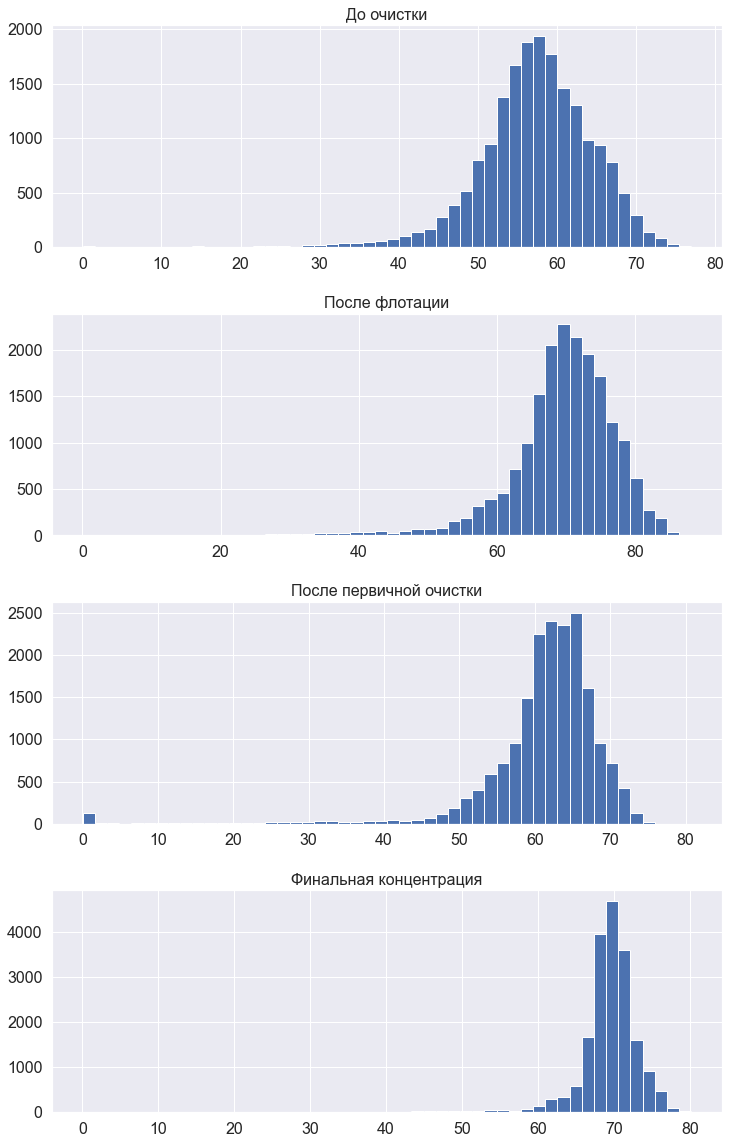

In [41]:
fig, ax = plt.subplots(4,1, figsize=(12,20))

processes.hist(bins=50,ax=ax);

titles = ['До очистки','После флотации', 'После первичной очистки', 'Финальная концентрация']

for i in range(len(titles)):
    ax[i].set_title(titles[i], fontsize=16);

In [42]:
processes[processes['primary_cleaner.output'] == 0]

,rougher.input,rougher.output,primary_cleaner.output,final.output
date,,,,


In [43]:
processes['primary_cleaner.output'].value_counts()

0.040000     117
62.032338      6
63.823562      5
59.095131      5
65.107626      3
            ... 
69.146987      1
65.034316      1
63.984043      1
59.185997      1
67.316511      1
Name: primary_cleaner.output, Length: 18715, dtype: int64

Нулевых значений концентраций не осталось, однако после первичной очистки все еще есть значение близкое к нулю. Так как оно явно является аномалией, так же избавимся от него, чтобы не было негативного влияния на модель. 

Поэтому уберем эти данные из выборок.

In [44]:
gold_test.shape

(5290, 52)

In [45]:
gold_test = gold_full.loc[gold_test.index, gold_test.columns]
gold_test = gold_test[
                (gold_full['rougher.output.concentrate_au'] != 0) & 
                (gold_full['primary_cleaner.output.concentrate_au'] > 0.04) &
                (gold_full['final.output.concentrate_au'] != 0)]
gold_test.shape

C:\Users\funkyabe\AppData\Local\Temp\ipykernel_13448\403032944.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gold_test = gold_test[


(5123, 52)

In [46]:
gold_train.shape

(14149, 86)

In [47]:
gold_train = gold_train[
                (gold_full['rougher.output.concentrate_au'] != 0) & 
                (gold_full['primary_cleaner.output.concentrate_au'] > 0.04) &
                (gold_full['final.output.concentrate_au'] != 0)]
gold_train.shape

C:\Users\funkyabe\AppData\Local\Temp\ipykernel_13448\1442591451.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gold_train = gold_train[


(13608, 86)

In [48]:
gold_train.shape[0] + gold_test.shape[0] == gold_full[
    (gold_full['rougher.output.concentrate_au'] != 0) & 
    (gold_full['primary_cleaner.output.concentrate_au'] > 0.04) &
    (gold_full['final.output.concentrate_au'] != 0)].shape[0]

True

In [49]:
gold_full[
    (gold_full['rougher.output.concentrate_au'] > gold_full['rougher.output.concentrate_au'].quantile(.005)) &
    (gold_full['rougher.output.concentrate_au'] < gold_full['rougher.output.concentrate_au'].quantile(.995)) &
    (gold_full['primary_cleaner.output.concentrate_au'] > gold_full['primary_cleaner.output.concentrate_au'].quantile(.005)) &
    (gold_full['primary_cleaner.output.concentrate_au'] < gold_full['primary_cleaner.output.concentrate_au'].quantile(.995)) &
    (gold_full['final.output.concentrate_au'] > gold_full['final.output.concentrate_au'].quantile(.005)) &
    (gold_full['final.output.concentrate_au'] < gold_full['final.output.concentrate_au'].quantile(.995))
     ]

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [50]:
gold_full['rougher.output.concentrate_au'].quantile(.005)

0.0

In [51]:
gold_full['primary_cleaner.output.concentrate_au'].quantile(.005)

0.0

In [52]:
gold_full['final.output.concentrate_au'].quantile(.005)

0.0018999999575316524

Аномалии устранены.

## Построение модели ##

### Расчет метрики ###

Так как параметр `recovery` - расчетный, то он отсутствует в тестовой выборке. Однако, именно он является для нас целевым, поэтому добавим его в выборку.

In [53]:
target_cols = ['rougher.output.recovery', 'final.output.recovery']
gold_test[target_cols] = gold_full.loc[gold_test.index, target_cols]
gold_test.shape

(5123, 54)

In [54]:
gold_test[target_cols].head()

,rougher.output.recovery,final.output.recovery
date,,
2016-09-01 00:59:59,89.993421,70.273583
2016-09-01 01:59:59,88.089657,68.910432
2016-09-01 02:59:59,88.412756,68.143213
2016-09-01 03:59:59,87.360133,67.776393
2016-09-01 04:59:59,83.236367,61.467078



Для решения задачи введём новую метрику качества — `sMAPE` (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Она вычисляется так:

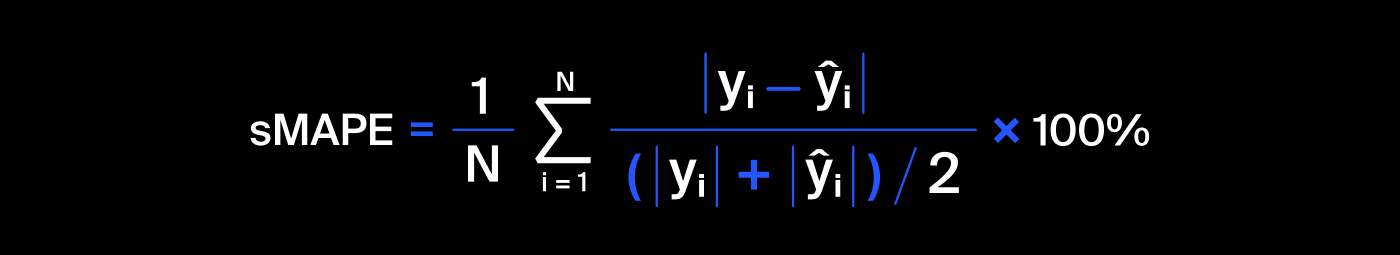

Напишем функцию для вычисления `sMAPE`.

In [55]:
def smape_score(target, predict):
    smape = ((abs(target-predict)) * 2 / (abs(target) + abs(predict))).mean() * 100
    return smape

In [56]:
smape_scorer = make_scorer(smape_score, greater_is_better=False)

Обученная модель должна прогнозировать сразу 2 величины, поэтому итоговая метрика складывается из двух величин: 25% sMAPE на флотации + 75% sMAPE после всех очисток.

Напишем функцию для расчета итоговой sMAPE

In [57]:
def overall_smape_score(data, model):
    
    rougher_features = (data
                        .loc[:,data.columns.str.contains('rougher')]
                        .drop(columns=['rougher.output.recovery']))
    rougher_target = data['rougher.output.recovery']
    
    final_features = (data
                      .loc[:,data.columns.str.contains('primary|secondary|final')]
                      .drop(columns=['final.output.recovery']))
    final_target = data['final.output.recovery']
    
    rougher_smape = cross_val_score(model, 
                                    rougher_features,
                                    rougher_target,
                                    scoring=smape_scorer,
                                    cv=5,
                                    n_jobs=4,).mean()
    
    final_smape = cross_val_score(model,
                                  final_features,
                                  final_target,
                                  scoring=smape_scorer,
                                  cv=5,
                                  n_jobs=4,).mean()
    
        
    smape = abs(0.25 * rougher_smape + 0.75 * final_smape)
    
   
    return smape

### Подбор гиперпараметров ###

Так как модель должна предсказывать насыщение золота по входным данным, отбросим из тренировочной выборки столбцы, не входящие в тестовую выборку.

Так как в функции для расчета итоговой sMAPE я прописано разделение фич и таргетов для rougher и final, то подбор гиперпараметров решено делать только на final-признаках. 

In [58]:
train_data = gold_train[gold_test.columns]
train_data.shape

(13608, 54)

In [59]:
state = np.random.RandomState(42)

features = (train_data
            .loc[:,train_data.columns.str.contains('primary|secondary|final')]
            .drop(columns=['final.output.recovery']))
target = train_data['final.output.recovery']

print(features.shape)
print(target.shape)

(13608, 30)
(13608,)


Проведем подбор гиперпарметров методом GridSearchCV. 
Подбор гиперпарметров будем проводить для 3 моделей: 
* DecisionTreeRegressor
* RandomForestRegressor
* GradientBoostingRegressor

В качестве оценки возьмем написанную ранее функцию для нахождения sMAPE.


In [60]:
%%time

bs_dtr = BayesSearchCV(
    DecisionTreeRegressor(random_state=state),
    search_spaces={
        'max_depth':Integer(1, 16),
        'min_samples_leaf':Integer(1, 6),
        'min_samples_split':Integer(2, 12),
    },
    scoring=smape_scorer,
    cv=3, 
    n_jobs=4,
    n_iter=10)
bs_dtr.fit(features, target)
print('Лучшие параметры:', bs_dtr.best_params_)
print('Лучшее sMAPE', abs(bs_dtr.best_score_))

Лучшие параметры: OrderedDict([('max_depth', 2), ('min_samples_leaf', 5), ('min_samples_split', 6)])
Лучшее sMAPE 12.151882421887995
CPU times: total: 688 ms
Wall time: 4.47 s


In [61]:
%%time

bs_rfr = BayesSearchCV(
    RandomForestRegressor(random_state=state),
    {
        'n_estimators':Integer(10, 110),
        'max_depth':Integer(1, 11),
        'min_samples_split':Integer(2, 8),
    },
    scoring=smape_scorer,
    cv=3, 
    n_jobs=4,
    n_iter=10
)
bs_rfr.fit(features, target)
print('Лучшие параметры:', bs_rfr.best_params_)
print('Лучшее sMAPE', abs(bs_rfr.best_score_))

Лучшие параметры: OrderedDict([('max_depth', 3), ('min_samples_split', 7), ('n_estimators', 96)])
Лучшее sMAPE 11.978383155801831
CPU times: total: 6.05 s
Wall time: 48.8 s


In [62]:
%%time

bs_gbr = BayesSearchCV(
    GradientBoostingRegressor(random_state=state), 
    {
        'n_estimators':Integer(20, 200),
        'max_depth':Integer(1, 11),
        'min_samples_split':Integer(2, 8),
    },
    scoring=smape_scorer, 
    cv=3, 
    n_jobs=4,
    n_iter=10
)
bs_gbr.fit(features, target)
print('Лучшие параметры:', bs_gbr.best_params_)
print('Лучшее sMAPE', abs(bs_gbr.best_score_))

Лучшие параметры: OrderedDict([('max_depth', 1), ('min_samples_split', 2), ('n_estimators', 64)])
Лучшее sMAPE 10.73175842668613
CPU times: total: 2.59 s
Wall time: 1min 52s


### Выбор модели ###

Для каждой модели найдем итоговое sMAPE и выберем модель с наилучшим результатом.

In [63]:
%%time

lr = LinearRegression()
dtr = bs_dtr.best_estimator_
rfr = bs_rfr.best_estimator_
gbr = bs_gbr.best_estimator_

models = [lr, dtr, rfr, gbr]
scores = {
    'model':[],
    'score':[],
}

for model in models:
    scores['model'].append(type(model).__name__)
    scores['score'].append(overall_smape_score(train_data, model))
    
scores = pd.DataFrame(scores)
display(scores)
print()
display('Лучшая модель:', scores.query('score == score.min()'))

,model,score
0,LinearRegression,8.869963
1,DecisionTreeRegressor,9.564707
2,RandomForestRegressor,9.388720
3,GradientBoostingRegressor,8.751319


'Лучшая модель:'

,model,score
3,GradientBoostingRegressor,8.751319


CPU times: total: 328 ms
Wall time: 22.5 s


In [64]:
best_model = None

for model in models:
    if type(model).__name__ == scores.query('score == score.min()')['model'].item():
        best_model = model
    
print(f'Лучшая модель - {best_model}')

Лучшая модель - GradientBoostingRegressor(max_depth=1, n_estimators=64,
                          random_state=RandomState(MT19937) at 0x2BBBAA24140)


Теперь проверим данную модель на тестовой выборке.

In [65]:
print(f'Итоговая sMAPE на тестовой выборке - {overall_smape_score(gold_test, best_model):.3}%')

Итоговая sMAPE на тестовой выборке - 6.61%


In [66]:
rougher_train_features = (train_data
                          .loc[:,train_data.columns.str.contains('rougher')]
                          .drop(columns=['rougher.output.recovery']))
rougher_train_target = train_data['rougher.output.recovery']

final_train_features = (train_data
                        .loc[:,train_data.columns.str.contains('primary|secondary|final')]
                        .drop(columns=['final.output.recovery']))
final_train_target = train_data['final.output.recovery']

rougher_test_features = (gold_test
                          .loc[:,gold_test.columns.str.contains('rougher')]
                          .drop(columns=['rougher.output.recovery']))
rougher_test_target = gold_test['rougher.output.recovery']

final_test_features = (gold_test
                        .loc[:,gold_test.columns.str.contains('primary|secondary|final')]
                        .drop(columns=['final.output.recovery']))
final_test_target = gold_test['final.output.recovery']

best_model.fit(rougher_train_features, rougher_train_target)
rougher_pred = best_model.predict(rougher_test_features)
rougher_smape = smape_score(rougher_test_target, rougher_pred)

best_model.fit(final_train_features, final_train_target)
final_pred = best_model.predict(final_test_features)
final_smape = smape_score(rougher_test_target, final_pred)

smape = abs(0.25 * rougher_smape + 0.75 * final_smape)

smape

19.392663311048555

In [67]:
dummy = DummyRegressor(strategy = 'mean')

dummy.fit(rougher_train_features, rougher_train_target)
dummy_rougher_pred = dummy.predict(rougher_test_features)
dummy_rougher_smape = smape_score(rougher_test_target, dummy_rougher_pred)

dummy.fit(final_train_features, final_train_target)
dummy_final_pred = dummy.predict(final_test_features)
dummy_final_smape = smape_score(rougher_test_target, dummy_final_pred)

dummy_smape = abs(0.25 * dummy_rougher_smape + 0.75 * dummy_final_smape)

dummy_smape

20.863583711032657

## Вывод ##

В ходе проекта были изучены данные о технологическом процессе очистки золотоносной руды. Для анализа были предоставлены 3 датасета, 2 из которых представляли собой обучающую и тестовую выборки из третьего исходного сета.

1. Первичный обзор показал, что в тестовой выборке отсутсвовали столбцы с расчетными данными, которые получаются позже. Выборки поделены приблизительно в соотношении 3:1. А так же во всех датасетах имеются пропуски значений.

2. По условию задачи, соседние по времени данные часто похожи, поэтому для заполнения пропусков использовались средние значения ближайших соседей. Кроме того, был проведен расчет параметра `recovery` для оценки правильности расчетных значений в таблице. 

3. Анализ изменения концентрации металлов после каждого этапа очистки показал, что концетрации золота и свинца увеличиваются, а серебра - увеличивается после флотации, однако уменьшается на последующих этапах. Кроме того, было проведено сравнение размеров гранул в тестовой и тренировочной выборках. Средний размер гранул в тестовой выборке получился чуть меньше, однако, так как единицы измерения гранул - микроны, разнице в 4 микрона можно пренебречь. Так же было проведено исследование суммарной концетрации веществ на всех этапах тех.процесса, которое показало, что благодаря очистке концетрация увеличивается и становится более однородной. Было обнаружено, что в концетрации присутсвуют нулевые значения, которые было решено отбросить, т.к. они могли исказить качество модели.

4. Последним этапом был подбор подходящей модели обучения. Для этого была написана функция для нахождения метрики `sMAPE`, а также функция считающая `итоговое sMAPE`для параметра `recovery` после флотации и после всех очисток. Методом GridSearch был произвден подбор гиперпараметров для трех моделей. Далее из них была выбрана модель с наилучшим показателем метрики, и также она была проверена на тестовой выборке.

Лучшей моделью оказалась GradientBoostingRegressor, итоговое sMAPE на тестовой выборке - 6.68%.